In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn, optim
from scipy import stats
from torch.functional import F
from torch.optim import Adam
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/RepLearning/VAE/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### References: 
https://github.com/CW-Huang/IFT6135H19_assignment/blob/master/assignment3/mnist_loader.ipynb

https://github.com/pytorch/examples/blob/master/vae/main.py

# Loading BinaryMNIST


In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [0]:
torch.manual_seed(42)
device = torch.device("cpu") # "cuda"
n_epochs = 20
log_interval = 100
batch_size = 64
latent_size = 100

In [8]:
train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", batch_size)


Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat



15687680it [00:20, 4296714.20it/s]                              

Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat


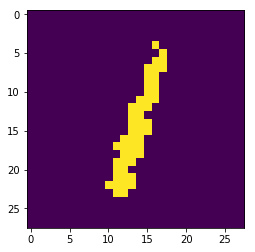

In [9]:
for x in train_loader:
    plt.imshow(x[0, 0])
    break

In [10]:
print('train: ', len(train_loader), '\nvalid: ', len(valid_loader), '\ntest:  ', len(test_loader))


train:  782 
valid:  157 
test:   157


# VAE Model
Uses the outlined architecture

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encoder layers
        self.conv1 = nn.Conv2d(1  , 32 , (3, 3))
        self.conv2 = nn.Conv2d(32 , 64 , (3, 3))
        self.conv3 = nn.Conv2d(64 , 256, (5, 5))
        self.fc1   = nn.Linear(256, 2*latent_size)
        
        # decoder layers
        self.fc2   = nn.Linear(latent_size, 256)
        self.conv4 = nn.Conv2d(256, 64, (5, 5), padding=(4,4))
        self.conv5 = nn.Conv2d(64 , 32, (3, 3), padding=(2,2))
        self.conv6 = nn.Conv2d(32 , 16, (3, 3), padding=(2,2))        
        self.conv7 = nn.Conv2d(16 , 1 , (3, 3), padding=(2,2))
        self.upsmple = nn.UpsamplingBilinear2d(scale_factor=2) #, mode='bilinear')

    def encode(self, x):
        xo = F.elu(self.conv1(x))
        xo = F.avg_pool2d(xo, kernel_size=2, stride=2)
        xo = F.elu(self.conv2(xo))
        xo = F.avg_pool2d(xo, kernel_size=2, stride=2)
        xo = F.elu(self.conv3(xo))
        xo = xo.reshape(-1,256)
        xo = self.fc1(xo)       
        return xo[:, :latent_size], xo[:, latent_size:] # mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        xo = F.elu(self.fc2(z))
        xo = xo.reshape(z.shape[0], 256, 1, 1)
        xo = F.elu(self.conv4(xo))
        xo = self.upsmple(xo)
        xo = F.elu(self.conv5(xo))
        xo = self.upsmple(xo)
        xo = F.elu(self.conv6(xo))
        xo = self.conv7(xo)
        return torch.sigmoid(xo)

    def forward(self, x):
        mu, logvar = self.encode(x)#.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3*1e-4)

In [0]:
# Reconstruction + KL divergence summed over all elements in the batch
def loss_function(recon_x, x, mu, logvar):
    # sums over all the pixels in each image and across the entire batch
    # later we average this over all images to obtain per instance loss
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = 0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())

    return BCE - KLD

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [0]:
def get_avg_per_instance_ELBO(data_loader):
    """
    Args:
        param1: data_loader  - validation/test data loader

    Returns:
        Average ELBO per instance over the entire dataset 
    """
    model.eval()
    loss = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss += loss_function(recon_batch, data, mu, logvar).item()

    loss = loss/len(data_loader.dataset)
    return -loss


# Training VAE - 20 epochs

In [13]:
n_epochs = 20
if __name__ == "__main__":
    for epoch in range(1, n_epochs + 1):
        train(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Train Epoch: 1 [0/50000]	Loss: 536.7001953125
Train Epoch: 1 [6400/50000]	Loss: 220.7176513671875
Train Epoch: 1 [12800/50000]	Loss: 193.59536743164062
Train Epoch: 1 [19200/50000]	Loss: 171.93695068359375
Train Epoch: 1 [25600/50000]	Loss: 168.14175415039062
Train Epoch: 1 [32000/50000]	Loss: 150.896240234375
Train Epoch: 1 [38400/50000]	Loss: 157.8760528564453
Train Epoch: 1 [44800/50000]	Loss: 145.53207397460938
====> Epoch: 1 Average loss: 184.47904995117187
Train Epoch: 2 [0/50000]	Loss: 146.45274353027344
Train Epoch: 2 [6400/50000]	Loss: 124.02973937988281
Train Epoch: 2 [12800/50000]	Loss: 130.306884765625
Train Epoch: 2 [19200/50000]	Loss: 124.01074981689453
Train Epoch: 2 [25600/50000]	Loss: 120.74786376953125
Train Epoch: 2 [32000/50000]	Loss: 126.5933609008789
Train Epoch: 2 [38400/50000]	Loss: 122.88883972167969
Train Epoch: 2 [44800/50000]	Loss: 117.56623077392578
====> Epoch: 2 Average loss: 126.19925832519532
Train Epoch: 3 [0/50000]	Loss: 115.54996490478516
Train Epoch

## Compute average per instance ELBO for Validation/Test datasets

In [14]:
ELBO_valid = get_avg_per_instance_ELBO(valid_loader)
print('Valid - average per-instance ELBO: {} '.format(ELBO_valid))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Valid - average per-instance ELBO: -94.25169111328125 


In [15]:
ELBO_test = get_avg_per_instance_ELBO(test_loader)
print('Test  - average per-instance ELBO: {} '.format(ELBO_test))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Test  - average per-instance ELBO: -93.62225546875 


In [0]:
# saves trained model
# torch.save(model, path+'vae_torch.model')

# Importance Sampling


In [0]:
model = torch.load(path+'vae_torch.model')

In [0]:
def get_samples(K, mu, sig):
    """
    Args:
        param1: int K  - number of samples
        param2: array mu (M,L) - mean from the encoder network
        param3: array sig (M,L) - std from encoder network

    Returns:
        samples of size (M,K,L) 
        M: batchsize, K: num samples, L: latent size
    """
    return np.array([stats.norm.rvs(loc=mi, scale=si, size = K, random_state=None) 
                  for mi,si in zip(mu,sig)]).transpose()


In [0]:
def get_log_px(model, data, samples):
    """
    Args:
        param1: trained torch model
        param2: array data (M,D)
        param3: array samples (M,K,L)

    Returns:
        An array of log p(x) for the batch of size M
        (log p(x_1), ..., log p(x_M))
    """

    K = samples.shape[1]
    mu, logvar = model.encode(data)
    mu = mu.data.numpy()
    sig = torch.sqrt(torch.exp(logvar)).data.numpy()
    log_px_batch = []

    for i,(x,z,m,s) in enumerate(zip(data,samples,mu,sig)): # iterate through a batch

        ### q(z|x): stores log_qzx for numerical stability
        qzx = stats.norm(loc=m,scale=s).pdf(z)
        log_qzx = np.sum(np.log(qzx), axis=1)

        ### p(z): stores log_pz for numerical stability
        pz = stats.norm.pdf(z)
        log_pz = np.sum(np.log(pz), axis=1)

        ### p(x|z): stores log_pxz for numerical stability
        z = z.reshape(K,1,-1)
        x_reconst = model.decode(torch.Tensor(z))
        x_reconst = x_reconst.data.numpy()
        # clip probabilities close to zero/one to prevent exception
        lower_clip = np.finfo(float).eps
        upper_clip = 1 - np.finfo(float).eps
        x_reconst = np.clip(x_reconst, lower_clip, upper_clip)
        x_reconst = torch.Tensor(x_reconst)
        log_pxz = np.sum((x * (x_reconst).log() + (1 - x) * (1 - x_reconst).log()).reshape(K,-1).data.numpy(),axis=1)

        # log p(x) = log(1/K) + log(sum(exp(log p(x|z)+log p(z)-log q(z|x))))
        terms = log_pxz + log_pz - log_qzx
        log_px = -np.log(K) + np.log(np.sum(np.exp(terms))) 

        log_px_batch.append(log_px)

    return log_px_batch


In [20]:
for i, data in enumerate(valid_loader):
  break
  
mu, logvar = model.encode(data)
mu = mu.data.numpy()
sig = torch.sqrt(torch.exp(logvar)).data.numpy()

# obtains samples (M,K,L) => (64, 200, 100)
samples = np.array([get_samples(200, mi, si) for (mi,si) in zip(mu,sig)]) 

log_px_batch = get_log_px(model,data,samples)
print(np.mean(log_px_batch))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


-85.53463030044941


## Compute average log-likelihood using importance sampling on Validation/Test datasets

In [0]:
def get_log_px_dataset(data_loader, K):
    """
    Args:
        param1: data loader for the dataset
        param2: K num samples

    Returns:
        An array of log p(x) for the batch of size M
        (log p(x_1), ..., log p(x_M))
    """

    log_px_all = []
    for i, data in enumerate(data_loader):
        data = data.to(device)
        mu, logvar = model.encode(data)
        mu = mu.data.numpy()
        sig = torch.sqrt(torch.exp(logvar)).data.numpy()

        # obtains samples (M,K,L) => (64, 200, 100)
        samples = np.array([get_samples(K, mi, si) for (mi,si) in zip(mu,sig)]) 

        log_px_batch = get_log_px(model,data,samples)
        log_px_all.extend(log_px_batch)

    return log_px_all

In [22]:
log_px_valid = get_log_px_dataset(valid_loader, 200)
print('Validation - average log-likelihood estimate: {} '.format(np.mean(log_px_valid)))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Validation - average log-likelihood estimate: -88.73825199924798 


In [17]:
log_px_test  = get_log_px_dataset(test_loader, 200)
print('Test - average log-likelihood estimate: {} '.format(np.mean(log_px_test)))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Test - average log-likelihood estimate: -88.07301650262484 
